# XGBoost for titanic dataset

See `../prelims/...` on loading and processing the data

In [1]:
import pandas as pd
import numpy as np

import sklearn as sk
import sklearn.metrics as sk_mt

import pickle as pkl

import xgboost as xgb

import matplotlib as mpl
import matplotlib.pyplot as pp
import matplotlib.cm as cm

import os

import re

Load the processed train-test set

In [2]:
TRAIN_TEST_PKL_PATH = '../prelims/train_test_data.pkl'

with open(TRAIN_TEST_PKL_PATH, 'rb') as fh: 
    data_dict = pkl.load(fh)
    
TRAIN_DF = data_dict['TRAIN_DF']
TEST_DF = data_dict['TEST_DF']
#
TRAIN_LABEL_SRS = data_dict['TRAIN_LABEL']
TEST_LABEL_SRS = data_dict['TEST_LABEL']

## Train & save the model

See the [manual](https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html)

In [3]:
MODEL_SAVE_PATH_JSON = os.path.join(os.path.abspath('.'), 'default_model.json')

xgb_model = xgb.XGBClassifier()
xgb_model.fit(TRAIN_DF, TRAIN_LABEL_SRS)
print(xgb_model)

print(xgb_model.feature_importances_)

xgb_model.save_model(MODEL_SAVE_PATH_JSON)
del xgb_model

[18:21:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
[0.00750906 0.03852673 0.17586017 0.29949617 0.01879573 0.02747199
 0.0207566  0.02004169 0.02726294 0.03339444 0.01255283 0.02275289
 0.07576278 0.         0.       

/home/cryo/anaconda3/envs/py36/lib/python3.6/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


## Load and Evaluate the model

Load the model and extract model predictions

In [4]:
xgb_model = xgb.XGBClassifier()
xgb_model.load_model(MODEL_SAVE_PATH_JSON)

PRED_PROBA_SRS = pd.Series(xgb_model.predict_proba(TEST_DF)[:,1], name='test_proba')

also load precitions from naive classifiers

(-0.05, 1.05)

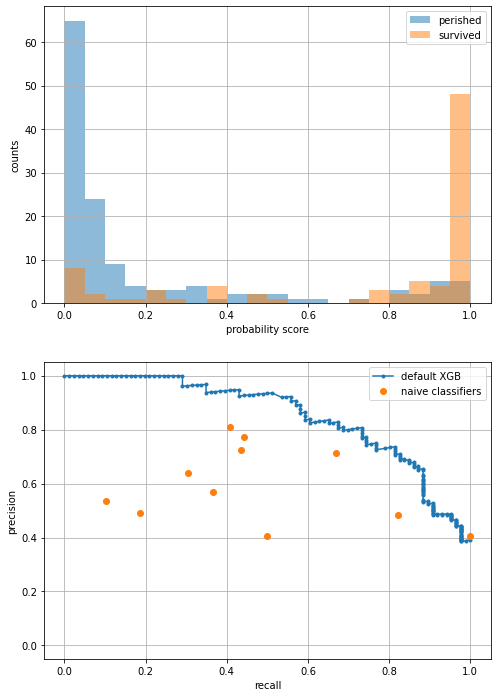

In [5]:
fig, ax = pp.subplots(2, 1, figsize=(8, 12))

bins = np.linspace(0, 1, 21)
#
ax[0].hist(PRED_PROBA_SRS[(TEST_LABEL_SRS==0).values], bins=bins, label='perished', alpha=0.5)
ax[0].hist(PRED_PROBA_SRS[(TEST_LABEL_SRS==1).values], bins=bins, label='survived', alpha=0.5)
ax[0].set_xlabel('probability score')
ax[0].set_ylabel('counts')
ax[0].legend()
ax[0].grid()

# precision-recall curve
precision, recall, thresholds = sk_mt.precision_recall_curve(TEST_LABEL_SRS, PRED_PROBA_SRS)
ax[1].plot(recall, precision, '.-', label='default XGB')

NAIVE_CLASSIFIERS_DF = pd.read_pickle('../prelims/naive_precision_recall.pkl')
ax[1].plot(NAIVE_CLASSIFIERS_DF.recall, NAIVE_CLASSIFIERS_DF.precision, 'o', label='naive classifiers')

ax[1].set_xlabel('recall')
ax[1].set_ylabel('precision')
ax[1].legend()
ax[1].grid()
ax[1].set_xlim([-0.05, 1.05])
ax[1].set_ylim([-0.05, 1.05])

So XGB does better than the naive classifiers mostly in the area of low recall. XGBoost is better at predicting who would have survived with high certainty, rather than capturing everyone who would have survived. In the second region, naive classifiers perform relatively well.

In [6]:
# Save predictions for further comparison
xgboost_pred_dict = {
    'TEST_DF': TEST_DF,
    'TEST_LABEL_SRS': TEST_LABEL_SRS,
    'PRED_PROBA_SRS': PRED_PROBA_SRS
}

with open('vanilla_xgb.pkl', 'wb') as fh:
    pkl.dump(xgboost_pred_dict, fh)

## Feature importance

Useful post [The Multiple faces of ‘Feature importance’ in XGBoost](https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7)

In [7]:
#define color coding for features
CLASSIFIER_CC = {
    'all_live': cm.tab20(0),
    'naive_Pclass': cm.tab20(1),
    'naive_Sex': cm.tab20(2),
    'naive_Age': cm.tab20(3),
    'naive_SibSp': cm.tab20(4),
    'naive_Parch': cm.tab20(5),
    'naive_Fare': cm.tab20(6),
    'naive_Cabin': cm.tab20(7),
    'naive_Deck': cm.tab20(7),
    'naive_Embarked': cm.tab20(8),
    'random_chance': cm.tab20(9),
}

FEATURE_CC = {
    'Pclass_1': CLASSIFIER_CC['naive_Pclass'],
    'Pclass_2': CLASSIFIER_CC['naive_Pclass'],
    'Pclass_3': CLASSIFIER_CC['naive_Pclass'],
    #
    'is_female': CLASSIFIER_CC['naive_Sex'],
    'is_miss': CLASSIFIER_CC['naive_Sex'],
    'age': CLASSIFIER_CC['naive_Age'],
    'sibsp_simp': CLASSIFIER_CC['naive_SibSp'],
    'parch_simp': CLASSIFIER_CC['naive_Parch'],
    'fare': CLASSIFIER_CC['naive_Fare'],
    #
    'deck_A': CLASSIFIER_CC['naive_Cabin'],
    'deck_B': CLASSIFIER_CC['naive_Cabin'],
    'deck_C': CLASSIFIER_CC['naive_Cabin'],
    'deck_D': CLASSIFIER_CC['naive_Cabin'],
    'deck_E': CLASSIFIER_CC['naive_Cabin'],
    'deck_F': CLASSIFIER_CC['naive_Cabin'],
    'deck_G': CLASSIFIER_CC['naive_Cabin'],
    'deck_MISSING': CLASSIFIER_CC['naive_Cabin'],
    'deck_T': CLASSIFIER_CC['naive_Cabin'],
    #
    'ticket_counter': CLASSIFIER_CC['naive_Cabin'],
    #
    'embarked_C': CLASSIFIER_CC['naive_Embarked'],
    'embarked_Q': CLASSIFIER_CC['naive_Embarked'],
    'embarked_S': CLASSIFIER_CC['naive_Embarked'],
    'embarked_nan': CLASSIFIER_CC['naive_Embarked']
}

In [8]:
# extract feature importances, and convert the 'f...' index-type names to proper feature names
feat_imp_type_list = ['gain', 'weight']

feat_imp_dd = {}

for i_fi, feat_imp_type in enumerate(feat_imp_type_list):
    raw_feature_importance_dict = xgb_model.get_booster().get_score(importance_type=feat_imp_type)

    feat_imp_dict = {
        ft_name:raw_feature_importance_dict[f'f{i_ft}'] if f'f{i_ft}' in raw_feature_importance_dict else 0 
        for i_ft, ft_name in enumerate(TRAIN_DF.columns) 
    }
    
    feat_imp_dd[feat_imp_type] = feat_imp_dict

Store feature importance dictionary for later comparison

In [9]:
with open('xgb_feature_imp.pkl', 'wb') as fh:
    pkl.dump(feat_imp_dd, fh)

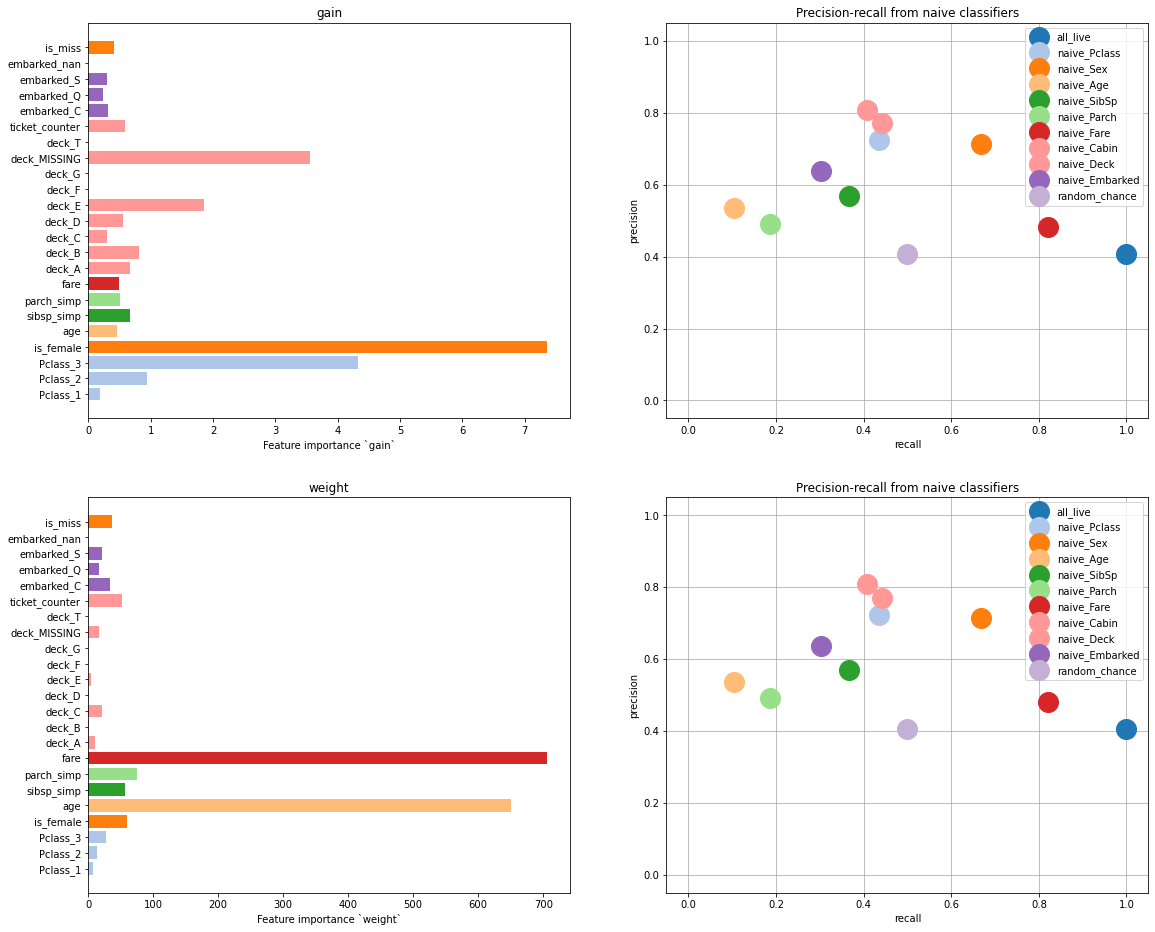

In [10]:


##############
# feature importance plot
fig, ax = pp.subplots(len(feat_imp_dd), 2, figsize=(19, 8*len(feat_imp_dd)))

for i_fi_type, (feat_imp_type, feat_imp_dict) in enumerate(feat_imp_dd.items()):

    bar_vert_pos = np.arange(len(feat_imp_dict))
    #
    feat_imps = np.zeros(len(feat_imp_dict), dtype=float)
    feat_names = []
    #
    for i_fi, (feat_name, feat_imp) in enumerate(feat_imp_dict.items()):
        feat_names.append(feat_name)
        feat_imps[i_fi] = feat_imp

        ax[i_fi_type, 0].barh(i_fi, feat_imp, color=FEATURE_CC[feat_name])

    ax[i_fi_type, 0].set_yticks(np.arange(len(feat_imp_dict)))
    ax[i_fi_type, 0].set_yticklabels(feat_names)
    ax[i_fi_type, 0].set_xlabel(f'Feature importance `{feat_imp_type}`')
    ax[i_fi_type, 0].set_title(feat_imp_type)

    #

    for _, row in NAIVE_CLASSIFIERS_DF.iterrows():
        ax[i_fi_type, 1].plot(row.recall, row.precision, 'o', label=row.nc_name, color=CLASSIFIER_CC[row.nc_name], markersize=20)

    ax[i_fi_type, 1].set_xlabel('recall')
    ax[i_fi_type, 1].set_ylabel('precision')
    ax[i_fi_type, 1].legend()
    ax[i_fi_type, 1].grid()
    ax[i_fi_type, 1].set_xlim([-0.05, 1.05])
    ax[i_fi_type, 1].set_ylim([-0.05, 1.05])
    ax[i_fi_type, 1].set_title('Precision-recall from naive classifiers')
    

* **Gain**-based feature improtance makes sense since it select as important those features that also make great naive classifers, with the exception of `fare`. The selected features here lead to largest reduction in loss function on average

* **Weight**-based feature importance shows in how many splits the feature is used. Tends to favour floating-point number values, since there is more to split there. Indeed this is what is observed. The two floating-point number features are ranked disproportionately high

Ignoring the other feature importance metrics, for now

## Viewing individual trees

Basic access to individual trees in text form.Good for querying

In [11]:
print(xgb_model.get_booster().get_dump()[1])

0:[f3<0.5] yes=1,no=2,missing=1
	1:[f15<0.5] yes=3,no=4,missing=3
		3:[f4<43] yes=7,no=8,missing=7
			7:[f12<0.5] yes=13,no=14,missing=13
				13:[f7<28.7250004] yes=23,no=24,missing=23
					23:leaf=-0.191184536
					24:[f18<0.5] yes=33,no=34,missing=33
						33:leaf=-0.0368194245
						34:leaf=0.214762002
				14:leaf=0.301630229
			8:[f4<47.5] yes=15,no=16,missing=15
				15:leaf=-0.351458788
				16:[f4<53] yes=25,no=26,missing=25
					25:leaf=0.107835867
					26:[f4<60.5] yes=35,no=36,missing=35
						35:leaf=-0.0743111297
						36:leaf=-0.279372424
		4:[f7<54.2479019] yes=9,no=10,missing=9
			9:[f6<0.5] yes=17,no=18,missing=17
				17:leaf=-0.357219696
				18:[f4<10] yes=27,no=28,missing=27
					27:[f5<1.5] yes=37,no=38,missing=37
						37:leaf=0.275776446
						38:leaf=-0.288350314
					28:leaf=-0.362172693
			10:[f7<58.9375] yes=19,no=20,missing=19
				19:leaf=0.28256765
				20:leaf=-0.357005477
	2:[f2<0.5] yes=5,no=6,missing=5
		5:leaf=0.393783212
		6:[f7<22.90415] yes=11,no=12,miss

Built-in visualiztion

<AxesSubplot:>

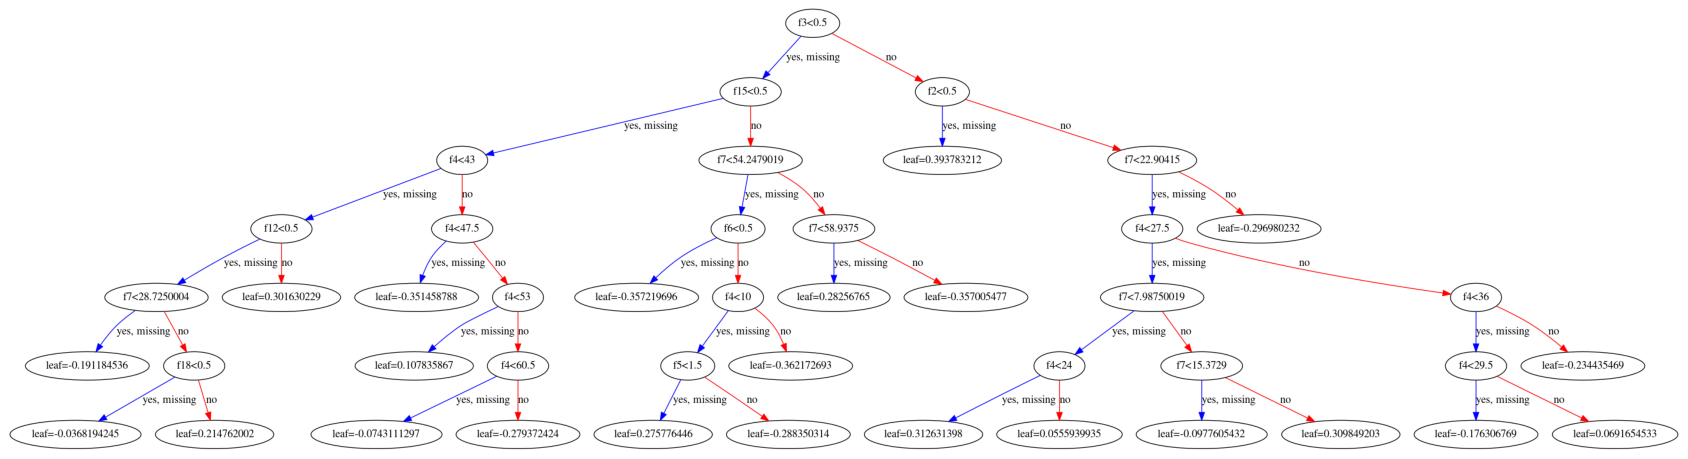

In [12]:
fig, ax = pp.subplots(figsize=(30, 20))

xgb.plot_tree(ax=ax, booster=xgb_model, num_trees=1)

## Statistics of leaf weights

In [13]:
leaf_weights = []
tree_inds = []

for i_tree, tree_str in enumerate(xgb_model.get_booster().get_dump()):
    
    cur_leaf_weights = []
    
    for leaf_weight_str in re.findall('(?<=:leaf=)([\.0-9+-]*)', tree_str):
        cur_leaf_weights.append(float(leaf_weight_str))
        
    
    cur_leaf_weights = {
        float(leaf_weight_str)
        for leaf_weight_str in
        re.findall('(?<=:leaf=)([\.0-9+-]*)', tree_str)
    }
    
    leaf_weights = [*leaf_weights, *cur_leaf_weights]
    tree_inds = [*tree_inds, *[i_tree]*len(cur_leaf_weights)]

(-0.75, 7.0)

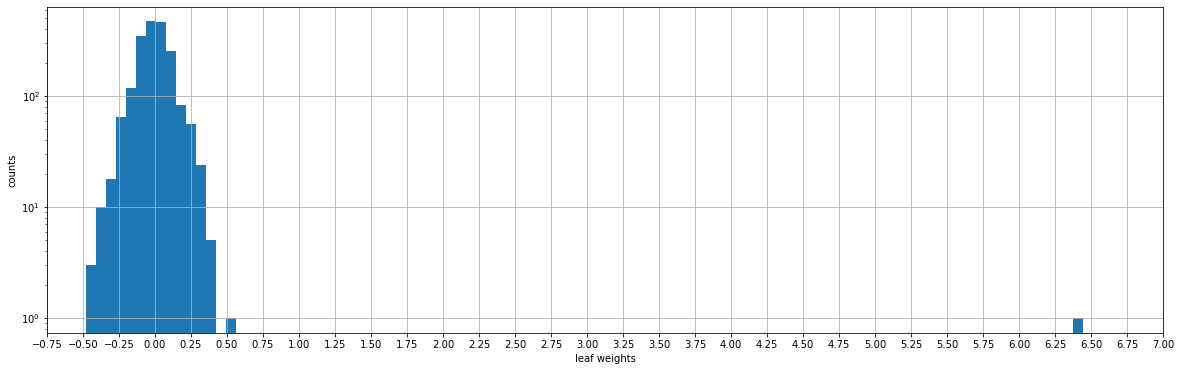

In [14]:
fig, ax = pp.subplots(figsize=(20, 6))

ax.hist(leaf_weights, bins=100)
ax.set_xlabel('leaf weights')
ax.set_ylabel('counts')
ax.set_yscale('log')
ax.grid()
_ = ax.set_xticks(np.arange(-10, 10, 0.25))
ax.set_xlim([-0.75, 7])

Where does the outlier at 6.0+ come from?

In [15]:
i_outlier_tree = [i_tree for i_tree, lw in zip(tree_inds, leaf_weights) if np.abs(lw)>6][0]

print(f'The tree with the outlier is #{i_outlier_tree}')

The tree with the outlier is #7


<AxesSubplot:>

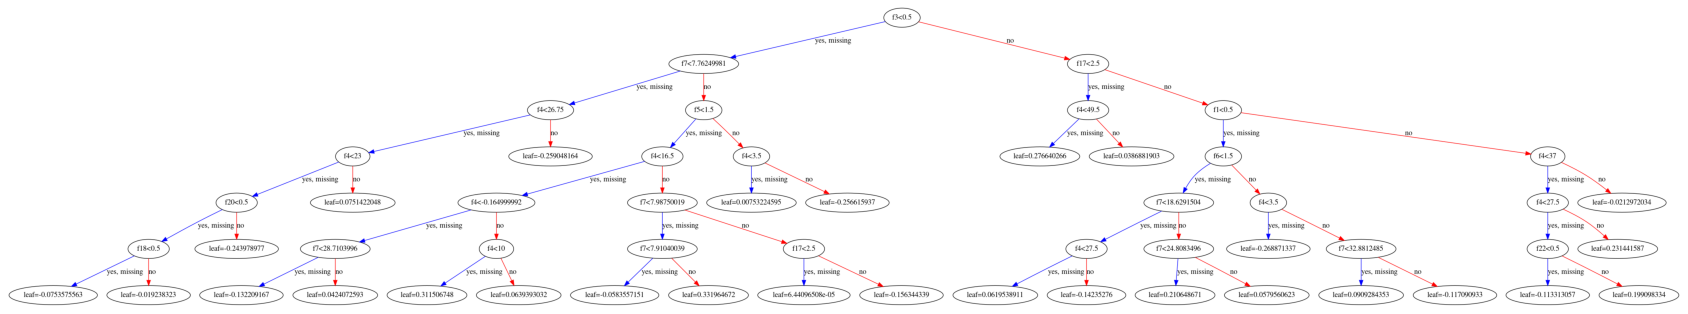

In [16]:
fig, ax = pp.subplots(figsize=(30, 20))

xgb.plot_tree(ax=ax, booster=xgb_model, num_trees=i_outlier_tree)

In [17]:
TRAIN_DF.columns[17]

'ticket_counter'

Presence of such large outliers could indicate some sort of special treatment for very few observations. Focus on `ticket_counter` here could indicate that for few observatios where three people shared the same cabin, the survival odds very significantly higher than others. 